# PoC - LC FILE PROCESSING

This notebook uses the `Gls` class to calculate and manage the Lomb-Scargle periodogram for a given TESS light curve.

(TO BE DEFINED) We will generate and store the file in a `fits` file, containing a main header and 2 _HDUs_:

- Header:
    - Object name (OBJECT = (KARMENES name))
    - Object common name (NAME = (Object common name) or None).
    - Object TIC id (TIC = (TESS identifier) or None).
    - Object right ascension, J2000 (RA_J2000 = 'RA_J2000')
    - Object declination, J2000 (DE_J2000 = 'DE_J2000')
    - Spectral type (SPTYPE = 'SpT')
    - Effective temperature in Kelvin (TEFF_K = 'Teff_K')
    - Logarithm of surface gravity (LOGG = 'logg')
    - Metallicity (FEH = 'FeH'
    - Luminosity compared to Sun's (L_LSUN = 'L_Lsol')
    - Radius compared to Sun's (R_RSUN = 'R_Rsol')
    - Mass compared to Sun's (M_MSUN = 'M_Msol')
    - Distance in parsec (D_PC = 'd_pc')
- HDU 1:
  - Data - The light curve, three columns:
    - time
    - flux
    - flux_err
  - Header - Must include at least the following values:
    - Object KARMENES name (OBJECT = (KARMENES name)).
    - Time units (PUNIT = u.d).
    - Frequency units (FUNIT = 1 / u.d).
    - Number of points in the light curve (RVPOINTS = gls.N).
    - Mean of RV (AGVFLUX = gls.\_Y)
    - RMS of RV (RMSFLUX = gls.\_YY).
    - Sampling period (the median of the difference values) (PSAMPLE = (calculated value)).
    - Sampling frequency (FSAMPLE = (1.0 / PSAMPLE).
    - Nyquist frequency (FNYQUIST = 0.5 * FSAMPLE).
- HDU 2:
  - Data - The calculated periodogram of the light curve, two columns:
    - freq
    - power
  - Header - Must include at least the following values:
    - Object KARMENES name (OBJECT = (KARMENES name).
    - Frequency units (FUNIT = 1 / u.d).
    - Period units (PUNIT = u.d).
    - Peak frequency (PK_FREQ = gls.best.e\_f).
    - Peak power (PK_POWER = gls.pmax).
    - Peak SNR (PK_SNR = BEST_A / gls.rms)
    - RMS of residuals (RES_RMS = gls.rms).
    - Sampling frequency (FSAMPLE = (1.0 / PSAMPLE)).
    - Nyquist frequency (FNYQUIST = 0.5 * FSAMPLE).
    - Number of frequency points (FPOINTS = (as chosen))
    - Start frequency (FBEG = gls.fbeg).
    - End frequency (FEND = gls.fend).
    - Frequency resolution (FRES = (calculated)).
    - Best frequency (F = gls.best.f).
    - Best frequency error (E_F = gls.best.e\_f).
    - Best period (P = gls.best.P).
    - Best period error (E_P = gls.best.e\_P).
    - Best amplitude (A = gls.best.A).
    - Best amplitude error (E_A = gls.best.e\_A).
    - Best phase (PH = gls.best.ph).
    - Best phase error (E_PH = gls.best.e\_ph).
    - Best reference epoch (T0 = gls.best.T0).
    - Best reference epoch error (E_T0 = gls.best.e\_T0).
    - Best offset (OFF = gls.best.offset).
    - Best offset error (E_OFF = gls.best.e\_offset).
    - Oversampling factor (OFAC = gls.ofac).
    - Maximum frequency factor (HIFAC = gls.hifac).
    - Normalization value (FNORM = gls.norm).
    - Lomb-Scargle calculation (i.e. not GLS) (LS = gls.ls (as chosen)).
    - Fast, recursive trigonometric calculations (FAST = gsl.fast (as chosen)).


## Modules and configuration

### Modules

In [1]:
# Modules import:
from collections import OrderedDict
import pandas as pd

# https://github.com/mzechmeister/GLS
from gls import Gls

import numpy as np

from scipy import stats

from astropy.table import Table, QTable
from astropy.timeseries import TimeSeries
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

import lightkurve as lk

%matplotlib inline
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 11, 11

#import seaborn as sns
#sns.set_style("white", {'figure.figsize':(15,10)})
#sns.set_style("whitegrid")
#sns.set(rc={'figure.figsize':(15,8)})

### Configuration

In [97]:
# Configuration:
DATA_FILE = "../data/GTO_objects_with_PG.csv"
# Files:
LC_INPUT_FILE = "../data/CARMENES_GTO_TESS_lc/lightcurves/J00051+457/J00051+457_TESS_TIC439946126_S17.fits"

PG_OUT_FILE = "../data/CARM_VIS_RVs_PGs/ETL_35_01_Test_LC_PG.fits"
IMAGE_LC_OUT = "./img/ETL_35_02_Test_Graph_TESS_LC_PG.png"


In [3]:
def tess_lc_load(filename: str):
    '''Load the TESS LC file and returns a lightcurve object with just the three relevant columns
    Note: it seems to be necessary to drop 'nan' values for GLS to work properly.'''
    lc_lk = lk.read(filename).remove_nans()
    return lc_lk

In [4]:
def lc_infer_sampling(lc_lk: lk.LightCurve):
    '''Infer sampling period from light curve'''
    time_diffs = lc_lk['time'][1:] - lc_lk['time'][:-1]
    return np.median(time_diffs)

## Trying downloading a TESS light curve

In [5]:
gto = pd.read_csv(DATA_FILE, sep=',', decimal='.')
gto.head()

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,T0_PG_TESS,e_T0_PG_TESS,offset_PG_TESS,e_offset_PG_TESS,FAP_PG_TESS,valid_PG_TESS,error_PG_TESS,elapsed_time_PG_TESS,fits_file_TESS,fig_file_TESS
0,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.003038,NaN,NaN
1,J23556-061,GJ 912,AB,912,358.913617,-6.144283,23:55:39.78,-06:08:33.4,88.129933,-65.175491,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000998,NaN,NaN
2,J23548+385,RX J2354.8+3831,-,NaN,358.713658,38.526340,23:54:51.46,+38:31:36.2,110.941908,-23.024449,...,1764.801553,0.011520,8262.210930,1.365308,0.999855,1.0,NaN,96.190682,../data/CARM_VIS_TESS_PGs/J23548+385_TESS_PG.fits,../data/CARM_VIS_TESS_PGs/figures/J23548+385_T...
3,J23505-095,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,80.777067,-67.303426,...,1354.108815,0.001261,7767.134654,0.094298,0.064148,1.0,NaN,473.533042,../data/CARMENES_GTO_TESS_PGs/J23505-095_TESS_...,../data/CARMENES_GTO_TESS_PGs/figures/J23505-0...
4,J23492+024,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,93.567467,-56.885396,...,NaN,NaN,NaN,NaN,NaN,0.0,Not recognized as a supported data product:\nn...,0.000984,NaN,NaN


In [6]:
print(list(gto.columns))

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

In [7]:
gto[(gto['lc_file'] == "<ambiguous>") & (gto['is_GTO'] == True)][['Karmn', 'Name', 'TIC_id']]

,Karmn,Name,TIC_id


In [8]:
search_result = lk.search_lightcurve("LP 763-012", author='TESS-SPOC', mission='TESS', exptime=1800)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESS-SPOC,1800,9697711,0.0


In [9]:
type(search_result)

lightkurve.search.SearchResult

In [10]:
len(search_result)

1

In [17]:
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESS-SPOC,1800,9697711,0.0


In [18]:
search_result[0].mission

array(['TESS Sector 02'], dtype=object)

In [19]:
search_result[0].mission[0][-2:]

'02'

In [20]:
lista_exposiciones = np.array(search_result.exptime.value)
lista_exposiciones

array([1800.])

In [21]:
np.argmax(lista_exposiciones)

0

In [22]:
lc = search_result[0].download()
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1354.1412776019956,7.7537632e+03,3.3089592e+00,5.2942033e-03,6080,267.67266,350.89367,7.2733740e+03,2.8284109e+00,1.5890396e+03,9.6352273e-01,7.7537632e+03,3.3089592e+00,0,———,———,———,———,267.67266,2.9562641e-04,350.89367,2.9606270e-04,5.6100626e-02,1.3295907e-01
1354.1621117685668,7.7594761e+03,3.3100913e+00,5.2950447e-03,6081,267.67281,350.89272,7.2789722e+03,2.8293784e+00,1.5881122e+03,9.6055984e-01,7.7594761e+03,3.3100913e+00,0,———,———,———,———,267.67281,2.9558814e-04,350.89272,2.9600266e-04,5.6142103e-02,1.3227622e-01
1354.182945932343,7.7529141e+03,3.3095551e+00,5.2958834e-03,6082,267.67279,350.89248,7.2719004e+03,2.8289196e+00,1.5885015e+03,9.6349335e-01,7.7529141e+03,3.3095551e+00,0,———,———,———,———,267.67279,2.9575152e-04,350.89248,2.9630968e-04,5.5929847e-02,1.3118161e-01
1354.2037800937912,7.7545757e+03,3.3090785e+00,5.2967197e-03,6083,267.67221,350.89164,7.2728408e+03,2.8285127e+00,1.5874463e+03,9.6101075e-01,7.7545757e+03,3.3090785e+00,0,———,———,———,———,267.67221,2.9579361e-04,350.89164,2.9633031e-04,5.5481974e-02,1.3045666e-01
1354.2246142519798,7.7525547e+03,3.3074827e+00,5.2975528e-03,6084,267.67210,350.89123,7.2719326e+03,2.8271484e+00,1.5872473e+03,9.6088183e-01,7.7525547e+03,3.3074827e+00,0,———,———,———,———,267.67210,2.9547623e-04,350.89123,2.9619472e-04,5.5814996e-02,1.3001455e-01
1354.2454484078398,7.7562227e+03,3.3076701e+00,5.2983835e-03,6085,267.67183,350.89070,7.2738467e+03,2.8273087e+00,1.5867924e+03,9.6095151e-01,7.7562227e+03,3.3076701e+00,0,———,———,———,———,267.67183,2.9552376e-04,350.89070,2.9590845e-04,5.5498924e-02,1.2933174e-01
1354.2662825609061,7.7563433e+03,3.3071494e+00,5.2992115e-03,6086,267.67139,350.89092,7.2735205e+03,2.8268635e+00,1.5860565e+03,9.5970803e-01,7.7563433e+03,3.3071494e+00,0,———,———,———,———,267.67139,2.9545804e-04,350.89092,2.9596357e-04,5.5295285e-02,1.2920165e-01
1354.287116711644,7.7591997e+03,3.3073804e+00,5.3000371e-03,6087,267.67139,350.88970,7.2749707e+03,2.8270609e+00,1.5847687e+03,9.6098500e-01,7.7591997e+03,3.3073804e+00,0,———,———,———,———,267.67139,2.9545926e-04,350.88970,2.9595103e-04,5.4747719e-02,1.2814769e-01


## Inspecting the TESS fits file

In [23]:
hdul = fits.open(LC_INPUT_FILE)

In [24]:
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000018ED7C38DF0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000018ED7CB4D90>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000018ED77C1E50>]

### Primary HDU

In [25]:
hdul[0]

In [26]:
hdul[0].name

'PRIMARY'

In [27]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-04-11'         / file creation date.                            
TSTART  =    1764.688076527806 / observation start time in BTJD                 
TSTOP   =    1789.682359955120 / observation stop time in BTJD                  
DATE-OBS= '2019-10-08T04:29:

In [28]:
hdul[0].data

### Light curve HDU

In [29]:
hdul[1]

In [30]:
hdul[1].name

'LIGHTCURVE'

In [31]:
hdul[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18012 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [32]:
hdul[1].data

FITS_rec([(1764.68321523, 0.00433111, 386801, nan, nan, nan, nan, nan, nan, 168, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1764.68460414, 0.00433113, 386802, nan, nan, nan, nan, nan, nan,  32, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1764.68599305, 0.00433115, 386803, nan, nan, nan, nan, nan, nan,  32, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          ...,
          (1789.69555433, 0.00418106, 404810, nan, nan, nan, nan, nan, nan,  16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1789.6969432 , 0.00418104, 404811, nan, nan, nan, nan, nan, nan,  16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (1789.69833207, 0.00418102, 404812, nan, nan, nan, nan, nan, nan,  16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)],
         dtype=(numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('SAP_FLUX', '>f4'), ('SAP_FLUX_ERR', '>f4'), ('SAP_BKG', '>f4'), ('SAP_BKG_ERR', '>f4'), ('PDCSAP_FL

In [33]:
type(hdul[1].data)

astropy.io.fits.fitsrec.FITS_rec

### Image HDU

In [34]:
hdul[2]

In [35]:
hdul[2].name

'APERTURE'

In [36]:
hdul[2].header

XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   11 / length of first array dimension                
NAXIS2  =                   13 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'APERTURE'           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

In [37]:
hdul[2].data

array([[257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257],
       [257, 257, 261, 261, 261, 261, 261, 261, 261, 261, 257],
       [257, 261, 261, 261, 257, 257, 257, 257, 257, 261, 261],
       [257, 257, 261, 261, 257, 257, 257, 257, 257, 261, 261],
       [257, 257, 261, 257, 257, 267, 267, 257, 257, 257, 257],
       [257, 257, 257, 257, 267, 267, 267, 267, 257, 257, 257],
       [257, 257, 257, 267, 267, 267, 267, 267, 267, 257, 257],
       [257, 257, 257, 267, 267, 267, 267, 267, 267, 257, 257],
       [261, 261, 257, 257, 267, 267, 267, 267, 267, 257, 257],
       [257, 257, 257, 257, 257, 267, 267, 267, 257, 257, 261],
       [257, 257, 261, 261, 257, 257, 257, 257, 257, 257, 261],
       [257, 261, 257, 261, 261, 257, 257, 257, 261, 261, 261],
       [257, 257, 257, 261, 261, 261, 261, 261, 257, 261, 257]])

### Close the hdul

In [38]:
hdul.close()

### Direct access with `lightcurve`

In [39]:
lc = lk.read(LC_INPUT_FILE)
type(lc)

lightkurve.lightcurve.TessLightCurve

In [40]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6887708664522,8.9227219e+04,3.6116268e+01,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,———,———,———,———,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02
1764.6901597747617,8.9208914e+04,3.6112118e+01,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,———,———,———,———,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02
1764.691548683071,8.9153250e+04,3.6124313e+01,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,———,———,———,———,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02
1764.692937591381,8.9087570e+04,3.6114269e+01,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,———,———,———,———,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02
1764.6943264996912,8.9209930e+04,3.6136734e+01,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,———,———,———,———,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02
1764.6957154075349,8.9232195e+04,3.6120758e+01,4.3312926e-03,386810,1735.53313,1882.66787,8.5803258e+04,3.4619461e+01,2.7502805e+03,1.0927849e+01,8.9232195e+04,3.6120758e+01,0,———,———,———,———,1735.53313,3.3751249e-04,1882.66787,3.3296234e-04,1.3339720e-02,5.8859117e-02
1764.6971043158442,8.9126555e+04,3.6123978e+01,4.3313126e-03,386811,1735.53014,1882.66736,8.5712211e+04,3.4622551e+01,2.7457996e+03,1.0923735e+01,8.9126555e+04,3.6123978e+01,0,———,———,———,———,1735.53014,3.3785202e-04,1882.66736,3.3398034e-04,1.0210144e-02,5.8872852e-02
1764.6984932241537,8.9152461e+04,3.6121216e+01,4.3313326e-03,386812,1735.52985,1882.66530,8.5709844e+04,3.4619900e+01,2.7462959e+03,1.0944048e+01,8.9152461e+04,3.6121216e+01,0,———,———,———,———,1735.52985,3.3859693e-04,1882.66530,3.3359075e-04,1.0727996e-02,5.7173919e-02


In [41]:
type(lc)

lightkurve.lightcurve.TessLightCurve

In [42]:
clean_lc = lc.remove_nans()
clean_lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6887708664522,8.9227219e+04,3.6116268e+01,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,———,———,———,———,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02
1764.6901597747617,8.9208914e+04,3.6112118e+01,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,———,———,———,———,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02
1764.691548683071,8.9153250e+04,3.6124313e+01,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,———,———,———,———,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02
1764.692937591381,8.9087570e+04,3.6114269e+01,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,———,———,———,———,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02
1764.6943264996912,8.9209930e+04,3.6136734e+01,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,———,———,———,———,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02
1764.6957154075349,8.9232195e+04,3.6120758e+01,4.3312926e-03,386810,1735.53313,1882.66787,8.5803258e+04,3.4619461e+01,2.7502805e+03,1.0927849e+01,8.9232195e+04,3.6120758e+01,0,———,———,———,———,1735.53313,3.3751249e-04,1882.66787,3.3296234e-04,1.3339720e-02,5.8859117e-02
1764.6971043158442,8.9126555e+04,3.6123978e+01,4.3313126e-03,386811,1735.53014,1882.66736,8.5712211e+04,3.4622551e+01,2.7457996e+03,1.0923735e+01,8.9126555e+04,3.6123978e+01,0,———,———,———,———,1735.53014,3.3785202e-04,1882.66736,3.3398034e-04,1.0210144e-02,5.8872852e-02
1764.6984932241537,8.9152461e+04,3.6121216e+01,4.3313326e-03,386812,1735.52985,1882.66530,8.5709844e+04,3.4619900e+01,2.7462959e+03,1.0944048e+01,8.9152461e+04,3.6121216e+01,0,———,———,———,———,1735.52985,3.3859693e-04,1882.66530,3.3359075e-04,1.0727996e-02,5.7173919e-02


## Sequential testing

### Data loading

In [43]:
# Load data:
lc_lk = tess_lc_load(LC_INPUT_FILE)
lc_lk

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6887708664522,8.9227219e+04,3.6116268e+01,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,———,———,———,———,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02
1764.6901597747617,8.9208914e+04,3.6112118e+01,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,———,———,———,———,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02
1764.691548683071,8.9153250e+04,3.6124313e+01,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,———,———,———,———,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02
1764.692937591381,8.9087570e+04,3.6114269e+01,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,———,———,———,———,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02
1764.6943264996912,8.9209930e+04,3.6136734e+01,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,———,———,———,———,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02
1764.6957154075349,8.9232195e+04,3.6120758e+01,4.3312926e-03,386810,1735.53313,1882.66787,8.5803258e+04,3.4619461e+01,2.7502805e+03,1.0927849e+01,8.9232195e+04,3.6120758e+01,0,———,———,———,———,1735.53313,3.3751249e-04,1882.66787,3.3296234e-04,1.3339720e-02,5.8859117e-02
1764.6971043158442,8.9126555e+04,3.6123978e+01,4.3313126e-03,386811,1735.53014,1882.66736,8.5712211e+04,3.4622551e+01,2.7457996e+03,1.0923735e+01,8.9126555e+04,3.6123978e+01,0,———,———,———,———,1735.53014,3.3785202e-04,1882.66736,3.3398034e-04,1.0210144e-02,5.8872852e-02
1764.6984932241537,8.9152461e+04,3.6121216e+01,4.3313326e-03,386812,1735.52985,1882.66530,8.5709844e+04,3.4619900e+01,2.7462959e+03,1.0944048e+01,8.9152461e+04,3.6121216e+01,0,———,———,———,———,1735.52985,3.3859693e-04,1882.66530,3.3359075e-04,1.0727996e-02,5.7173919e-02


### GLS Periodogram

#### Calculation conditions

The stars currently under analysis are in the $He_{3}$ instability band, so they are expected to have effective temperatures in the range $T_{eff}\in[3300, 4300] K$, $\log g\in[4.5, 5.1]$, and masses in the range $M_{star}\in[0.20, 0.60] M_{Sun}$.

According to _Table 2_ in _The theoretical instability strip of M dwarf stars (Rodríguez-López, C., et al. 2014, MNRAS, 438, 2371)_ these stars have typical periods of $20 min$ to $3 h$, so we will set the limits of the periodogram frequencies for periods between $10 min$ and $5 h$. In days, this corresponds to a range of $P\in[0.006944, 0.208333] d$ or, equivalently, frequencies in the range $f\in[144, 4.8] d^{-1}$.

We will use the default "ZK" normalization.

#### Create instance

**Note:** we write all the parameters even if we use the default values, just to have them as a reference.

In [44]:
t = lc_lk['time'].value
y = lc_lk['flux'].value
e_y = lc_lk['flux_err'].value


In [45]:
t

array([1764.68877087, 1764.69015977, 1764.69154868, ..., 1787.96086406,
       1787.96225292, 1787.96364178])

In [46]:
np.array(y)

array([89227.22 , 89208.914, 89153.25 , ..., 89066.81 , 89118.32 ,
       89199.79 ], dtype=float32)

In [47]:
np.array(e_y)

array([36.11627 , 36.112118, 36.124313, ..., 37.307682, 37.286892,
       37.29453 ], dtype=float32)

In [48]:
# Create GLS instance:
gls = Gls((lc_lk['time'].value, np.array(lc_lk['flux'].value), np.array(lc_lk['flux_err'].value)),
          fbeg=4.8, fend=144, Pbeg=None, Pend=None, ofac=10, hifac=1, freq=None,
          norm="ZK", ls=False, fast=False, verbose=False)
gls

####  Check some attributes

The time series in array form:

In [49]:
gls.t

array([1764.68877087, 1764.69015977, 1764.69154868, ..., 1787.96086406,
       1787.96225292, 1787.96364178])

In [50]:
gls.y

array([89227.22 , 89208.914, 89153.25 , ..., 89066.81 , 89118.32 ,
       89199.79 ], dtype=float32)

In [51]:
gls.e_y

array([36.11627 , 36.112118, 36.124313, ..., 37.307682, 37.286892,
       37.29453 ], dtype=float32)

The periodogram power in array form:

In [52]:
gls.power

array([1.06636767e-05, 1.21893848e-05, 1.86688531e-05, ...,
       5.74574439e-05, 6.14620497e-05, 5.90621759e-05])

The periodogram frequencies (x axis) in array form:

In [53]:
gls.freq

array([  4.8       ,   4.80429648,   4.80859296, ..., 143.98874188,
       143.99303836, 143.99733484])

In [54]:
type(gls.freq)

numpy.ndarray

In [55]:
gls.freq.shape

(32399,)

#### Full information on the `GLS` object

In [56]:
gls.info(stdout=True)

Generalized LS - statistical output
-----------------------------------
Number of input points:      13073
Weighted mean of dataset:   89135.781250
Weighted rms of dataset:    56.381531
Time base:                  23.274871
Number of frequency points:  32399

Maximum power p [ZK]: 0.001649
FAP(pmax):            0.06490057520185222
RMS of residuals:     56.335026
  Mean weighted internal error:  36.179528
Best sine frequency:  38.046156 +/- 0.006929
Best sine period:     0.026284 +/- 0.000005
Amplitude:            3.239065 +/- 0.696796
-----------------------------------


And with a return value (interesting to store in the results array for all GTO stars):

In [57]:
gls_info = gls.info(stdout=False)
gls_info

'Generalized LS - statistical output\n-----------------------------------\nNumber of input points:      13073\nWeighted mean of dataset:   89135.781250\nWeighted rms of dataset:    56.381531\nTime base:                  23.274871\nNumber of frequency points:  32399\n\nMaximum power p [ZK]: 0.001649\nFAP(pmax):            0.06490057520185222\nRMS of residuals:     56.335026\n  Mean weighted internal error:  36.179528\nBest sine frequency:  38.046156 +/- 0.006929\nBest sine period:     0.026284 +/- 0.000005\nAmplitude:            3.239065 +/- 0.696796\n-----------------------------------'

#### Recover and calculate interesting values

It can be interesting to store some or all of the following key values in their own, separate columns in the results table for all GTO objects.

Number of points in RV curve:

In [58]:
gls.N

13073

Weighted mean of RV curve:

In [59]:
gls._Y

89135.78

Weighted rms of RV curve:

In [60]:
gls._YY

3178.877

Best period in days and error:

In [61]:
gls.best['P']

0.026283863943923

In [62]:
gls.best['e_P']

4.786718631207757e-06

Best period in hours and error:

In [63]:
24.0 * gls.best['P']

0.630812734654152

In [64]:
24.0 * gls.best['e_P']

0.00011488124714898616

Best period in minutes and error:

In [65]:
24.0 * 60.0 * gls.best['P']

37.84876407924912

In [66]:
24.0 * 60.0 * gls.best['e_P']

0.006892874828939169

Signal amplitude and error:

In [67]:
gls.best['amp']

3.2390648774180963

In [68]:
gls.best['e_amp']

0.696796345071788

Maximum periodogram power:

In [69]:
gls.power.max()

0.00164895749968701

RMS of residuals:

In [70]:
gls.rms

56.33502569567678

#### Modified plot of the light curve

As in the case of instance creation, we put all the paremeters as a reference, even if default values are used.

c:\users\ciroe\gls.py:645: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


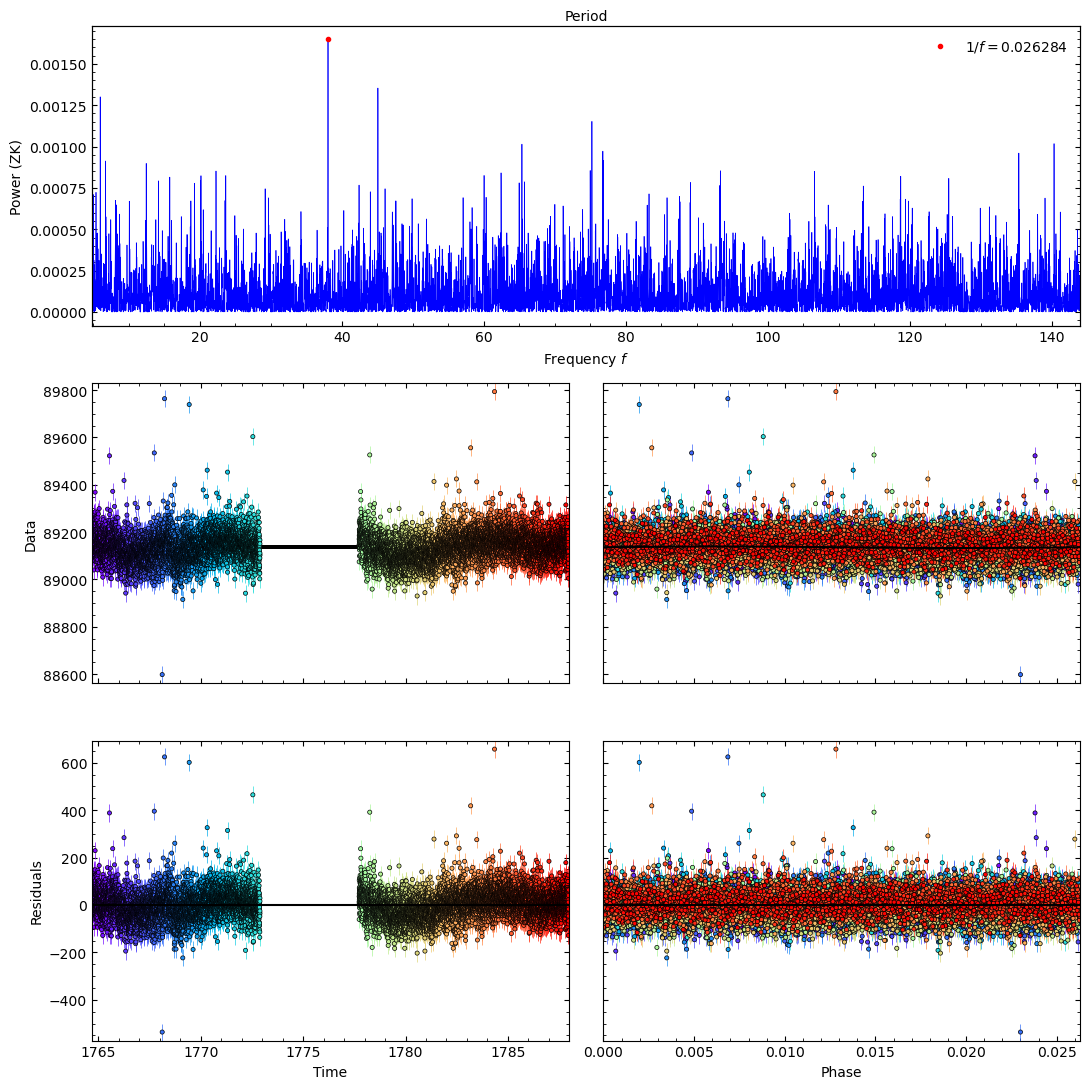

In [71]:
# Standard plot:
fig = gls.plot(block=False, period=False, fap=None, gls=True, data=True, residuals=True);

We now elaborate a slightly customized plot:

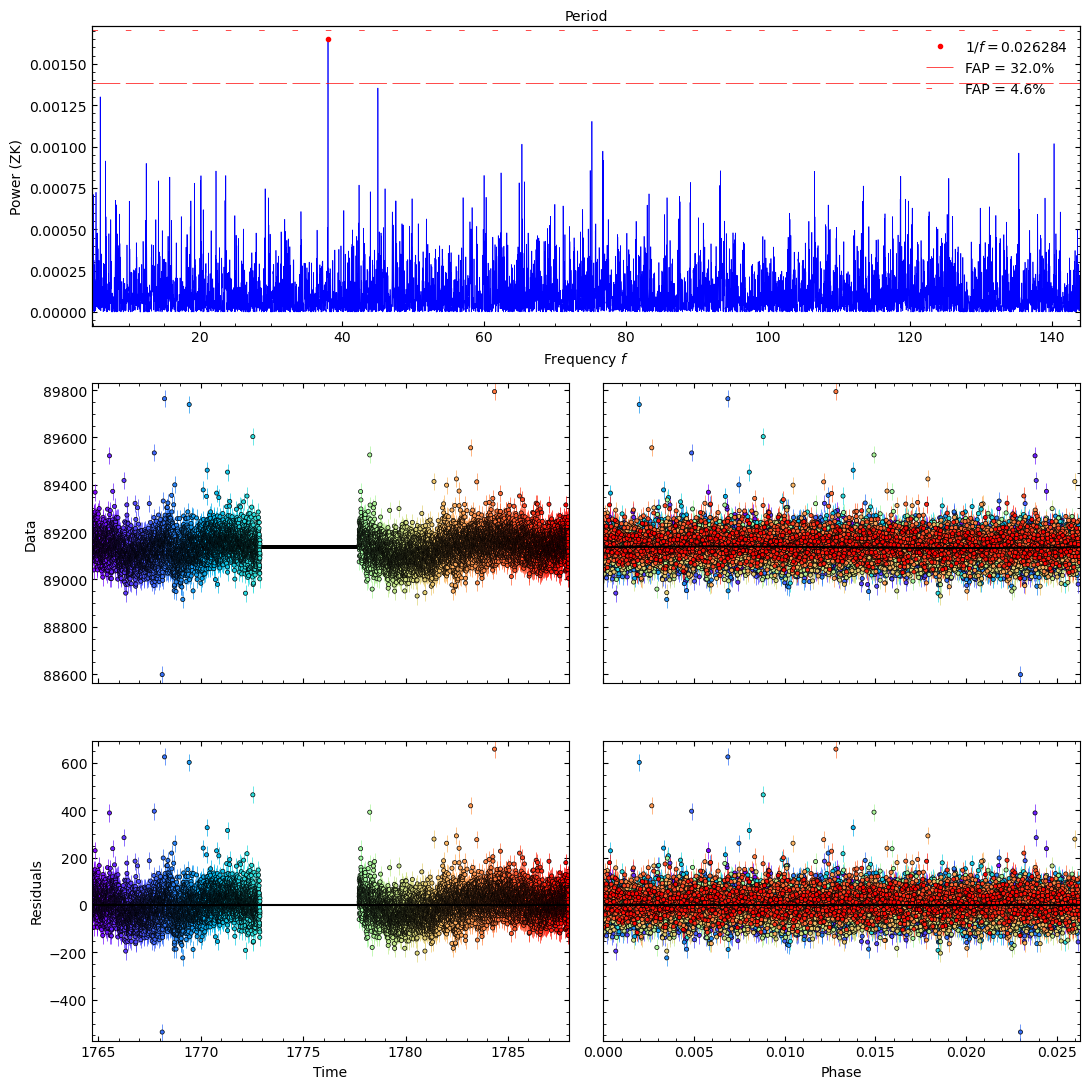

In [72]:
# Standard plot:
fig = gls.plot(block=False, period=False,
               fap=[0.3200, 0.0460], gls=True, data=True, residuals=True);

In [73]:
fig.suptitle("J00051+457")
fig.tight_layout()
fig.savefig(IMAGE_LC_OUT)

## Store the lightcurve and periodogram in 'fits' format

We will generate and store the file in a `fits` file, containing a main header and 2 _HDUs_, as described above:    

### Generate a primary `HDU` for basic header information

At the moment, the header contains just the object name:

In [74]:
primary_header = fits.Header()

In [75]:
primary_header['OBJECT'] = ("J00051+457", "KARMENES target name")
primary_header['NAME'] = ("GJ 2", "Object common name")
primary_header['TIC'] = ("439946126", "Object TESS identifier")
primary_header['RA_J2000'] = ("00:05:10.89", "Object right ascension (J2000)")
primary_header['DE_J2000'] = ("+45:47:11.6", "Object declination (J2000)")
primary_header['SPTYPE'] = ("M1.0 V", "Spectral type")
primary_header['TEFF_K'] = (3773, "Effective temperature in Kelvin")
primary_header['LOGG'] = (5.07, "Logarithm of surface gravity")
primary_header['FEH'] = (-0.04, "Metallicity")
primary_header['L_LSUN'] = (0.0436229, "Luminosity in Solar luminosities")
primary_header['R_RSUN'] = (0.48881, "Radius in Solar radii")
primary_header['M_MSUN'] = (0.4918, "Mass in Solar masses")
primary_header['D_PC'] = (11.50352803, "Distance in parsec")


In [76]:
hdu_primary = fits.PrimaryHDU(header=primary_header)

In [77]:
hdu_primary.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
OBJECT  = 'J00051+457'         / KARMENES target name                           
NAME    = 'GJ 2    '           / Object common name                             
TIC     = '439946126'          / Object TESS identifier                         
RA_J2000= '00:05:10.89'        / Object right ascension (J2000)                 
DE_J2000= '+45:47:11.6'        / Object declination (J2000)                     
SPTYPE  = 'M1.0 V  '           / Spectral type                                  
TEFF_K  =                 3773 / Effective temperature in Kelvin                
LOGG    =                 5.07 / Logarithm of surface gravity                   
FEH     =                -0.04 / Metallicity                                    
L_LSUN  =            0.04362

### Generate the `QTable` instances

Generate a `QTable` object containing the RV curve.

In [78]:
lc_lk.head()

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6887708664522,8.9227219e+04,3.6116268e+01,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,———,———,———,———,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02
1764.6901597747617,8.9208914e+04,3.6112118e+01,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,———,———,———,———,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02
1764.691548683071,8.9153250e+04,3.6124313e+01,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,———,———,———,———,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02
1764.692937591381,8.9087570e+04,3.6114269e+01,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,———,———,———,———,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02
1764.6943264996912,8.9209930e+04,3.6136734e+01,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,———,———,———,———,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02


In [79]:
lc_tbl = QTable(lc_lk.to_table())['time', 'flux', 'flux_err']
lc_tbl

time,flux,flux_err
,electron / s,electron / s
Time,float32,float32
1764.6887708664522,8.9227219e+04,3.6116268e+01
1764.6901597747617,8.9208914e+04,3.6112118e+01
1764.691548683071,8.9153250e+04,3.6124313e+01
1764.692937591381,8.9087570e+04,3.6114269e+01
1764.6943264996912,8.9209930e+04,3.6136734e+01
1764.6957154075349,8.9232195e+04,3.6120758e+01
1764.6971043158442,8.9126555e+04,3.6123978e+01
1764.6984932241537,8.9152461e+04,3.6121216e+01


Generate a `QTable` object containing the periodogram.

In [80]:
pg_tbl = QTable(data=[gls.freq, gls.power], names=['freq', 'power'], units=[1.0 / u.d, (u.electron / u.s) ** 2])
pg_tbl

freq,power
1 / d,electron2 / s2
float64,float64
4.8,1.0663676732739883e-05
4.804296479253116,1.218938479203516e-05
4.808592958506233,1.8668853117364395e-05
4.812889437759349,2.5373547164781256e-05
4.817185917012465,2.8278956959478107e-05
4.821482396265582,2.534154415949189e-05
4.825778875518698,1.7232079275728933e-05
4.8300753547718145,7.335364463819828e-06


### Generate the header units

#### Radial velocity curve

In [81]:
hdu_lc = fits.table_to_hdu(lc_tbl)

In [82]:
hdu_lc.name = "TESS_LC"

In [83]:
hdu_lc.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                13073 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIMESYS = 'TDB     '           / Default time scale                             
JDREF   =                  0.0 / Time columns are jd = jd1 + jd2                
TREFPOS = 'TOPOCENTER'         / Time reference position                        
TTYPE1  = 'time    '                                                            
TFORM1  = '2D      '        

In [84]:
hdu_lc.data[:10]

FITS_rec([([ 2.45876500e+06, -3.11229134e-01], 89227.22 , 36.11627 ),
          ([ 2.45876500e+06, -3.09840225e-01], 89208.914, 36.112118),
          ([ 2.45876500e+06, -3.08451317e-01], 89153.25 , 36.124313),
          ([ 2.45876500e+06, -3.07062409e-01], 89087.57 , 36.11427 ),
          ([ 2.45876500e+06, -3.05673500e-01], 89209.93 , 36.136734),
          ([ 2.45876500e+06, -3.04284592e-01], 89232.195, 36.120758),
          ([ 2.45876500e+06, -3.02895684e-01], 89126.555, 36.123978),
          ([ 2.45876500e+06, -3.01506776e-01], 89152.46 , 36.121216),
          ([ 2.45876500e+06, -3.00117868e-01], 89155.22 , 36.077877),
          ([ 2.45876500e+06, -2.98728960e-01], 89130.61 , 36.09987 )],
         dtype=(numpy.record, [('time', '<f8', (2,)), ('flux', '<f4'), ('flux_err', '<f4')]))

In [85]:
psample = lc_infer_sampling(lc_lk).value
fsample = 1.0 / psample
fnyq = 2.0 * fsample
freq_units = u.d ** (-1)

In [86]:
# Add values to header:
hdu_lc.header['OBJECT'] = ("J00051+457", "KARMENES target name")
hdu_lc.header['PUNIT'] = u.d.to_string(format='fits')
hdu_lc.header['FUNIT'] = freq_units.to_string(format='fits')
hdu_lc.header['RVPOINTS'] = (gls.N, "Number of points in the RV curve")
hdu_lc.header['AVGFLUX'] = (gls._Y, "Average flux of RV curve")
hdu_lc.header['RMSFLUX'] = (gls._YY, "Flux RMS of RV curve")
hdu_lc.header['PSAMPLE'] = (psample, "Inferred cadence in RV curve")
hdu_lc.header['FSAMPLE'] = (fsample, "Inferred sampling frequency in RV curve")
hdu_lc.header['FNYQUIST'] = (fnyq, "Calculated Nyquist frequency value")
hdu_lc.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                13073 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIMESYS = 'TDB     '           / Default time scale                             
JDREF   =                  0.0 / Time columns are jd = jd1 + jd2                
TREFPOS = 'TOPOCENTER'         / Time reference position                        
TTYPE1  = 'time    '                                                            
TFORM1  = '2D      '        

#### Periodogram

In [87]:
hdu_pg = fits.table_to_hdu(pg_tbl)

In [88]:
hdu_pg.name = "GLS_PG"

In [89]:
hdu_pg.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                32399 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'freq    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'd-1     '                                                            
TTYPE2  = 'power   '                                                            
TFORM2  = 'D       '        

In [90]:
hdu_pg.data[:10]

FITS_rec([(4.8       , 1.06636767e-05), (4.80429648, 1.21893848e-05),
          (4.80859296, 1.86688531e-05), (4.81288944, 2.53735472e-05),
          (4.81718592, 2.82789570e-05), (4.8214824 , 2.53415442e-05),
          (4.82577888, 1.72320793e-05), (4.83007535, 7.33536446e-06),
          (4.83437183, 1.02518792e-06), (4.83866831, 4.41174415e-06)],
         dtype=(numpy.record, [('freq', '<f8'), ('power', '<f8')]))

In [91]:
fpoints = len(gls.f)
fres = (gls.fend - gls.fbeg) / (fpoints - 1)

In [92]:
# Add values to header:
hdu_pg.header['OBJECT'] = ("J00051+457", "KARMENES target name")
hdu_pg.header['FUNIT'] = (freq_units.to_string(format='fits'), "Unit for frequencies")
hdu_pg.header['PUNIT'] = (u.d.to_string(format='fits'), "Unit for periods")
hdu_pg.header['PK_FREQ'] = (gls.best['f'], "Frequency of the peak in periodogram")
hdu_pg.header['PK_POW'] = (gls.pmax, "Power of the peak in periodogram")
hdu_pg.header['PK_SNR'] = (gls.pmax, "Power of the peak in periodogram")
hdu_pg.header['RES_RMS'] = (gls.rms, "RMS of residuals in periodogram")
hdu_pg.header['FSAMPLE'] = (fsample, "Inferred sampling frequency in RV curve")
hdu_pg.header['FNYQUIST'] = (fnyq, "Calculated Nyquist frequency value")
hdu_pg.header['FPOINTS'] = (fpoints, "Number of points in periodogram")
hdu_pg.header['FBEG'] = (gls.fbeg, "Start frequency in periodogram")
hdu_pg.header['FEND'] = (gls.fend, "End frequency in periodogram")
hdu_pg.header['FRES'] = (fres, "Frequency resolution in periodogram")
hdu_pg.header['F'] = (gls.best['f'], "Peak best estimate: frequency")
hdu_pg.header['E_F'] = (gls.best['e_f'], "Peak best estimate: frequency error")
hdu_pg.header['P'] = (gls.best['P'], "Peak best estimate: period")
hdu_pg.header['E_P'] = (gls.best['e_P'], "Peak best estimate: period error")
hdu_pg.header['A'] = (gls.best['amp'], "Peak best estimate: amplitude")
hdu_pg.header['E_A'] = (gls.best['e_amp'], "Peak best estimate: amplitude error")
hdu_pg.header['PH'] = (gls.best['ph'], "Peak best estimate: phase")
hdu_pg.header['E_PH'] = (gls.best['e_ph'], "Peak best estimate: phase error")
hdu_pg.header['T0'] = (gls.best['T0'], "Peak best estimate: frequency")
hdu_pg.header['E_T0'] = (gls.best['e_T0'], "Peak best estimate: frequency error")
hdu_pg.header['OFF'] = (gls.best['offset'], "Peak best estimate: offset")
hdu_pg.header['E_OFF'] = (gls.best['e_offset'], "Peak best estimate: offset error")
hdu_pg.header['OFAC'] = (gls.ofac, "Setup: oversampling factor")
hdu_pg.header['HIFAC'] = (gls.ofac, "Setup: maximum frequency factor")
hdu_pg.header['NORM'] = (gls.norm, "Setup: normalization type")
hdu_pg.header['LS'] = (gls.ls, "Setup: conventional Lomb-Scargle calculation")
hdu_pg.header['FAST'] = (gls.ofac, "Setup: fast evaluation, recursive trigonometric")
hdu_pg.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                32399 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'freq    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'd-1     '                                                            
TTYPE2  = 'power   '                                                            
TFORM2  = 'D       '        

### Create the fits object with the header and the two `HDU`

In [93]:
hdul = fits.HDUList([hdu_primary, hdu_lc, hdu_pg])

In [94]:
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000018EEA16FE20>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000018EE9F396A0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000018EE9CEC520>]

### Write the `fits` object to file

In [98]:
hdul.writeto(PG_OUT_FILE, overwrite=True)

**NOTE:** it is important to close the `HDUList` object after use, as well as also delete the read data, so as to eliminate all the pointers to the file (see https://docs.astropy.org/en/stable/io/fits/index.html#working-with-large-files).

In [99]:
hdul.close()

In [100]:
del hdul

In [101]:
del hdu_primary

In [102]:
del hdu_lc

In [103]:
del hdu_pg

### Test opening recently created `fits`file and working with it

In [104]:
read_hdul = fits.open(PG_OUT_FILE, mode='update', memmap=False)
read_hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000018EEA0AED90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000018EEC6111F0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000018EEC611A60>]

In [105]:
read_hdul.info()

Filename: ../data/CARM_VIS_RVs_PGs/ETL_35_01_Test_LC_PG.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  TESS_LC       1 BinTableHDU    146   13073R x 3C   [2D, E, E]   
  2  GLS_PG        1 BinTableHDU     44   32399R x 2C   [D, D]   


#### Retrieve basic information

In [106]:
read_hdul['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OBJECT  = 'J00051+457'         / KARMENES target name                           
NAME    = 'GJ 2    '           / Object common name                             
TIC     = '439946126'          / Object TESS identifier                         
RA_J2000= '00:05:10.89'        / Object right ascension (J2000)                 
DE_J2000= '+45:47:11.6'        / Object declination (J2000)                     
SPTYPE  = 'M1.0 V  '           / Spectral type                                  
TEFF_K  =                 3773 / Effective temperature in Kelvin                
LOGG    =                 5.07 / Logarithm of surface gravity                   
FEH     =                -0.

In [107]:
read_hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OBJECT  = 'J00051+457'         / KARMENES target name                           
NAME    = 'GJ 2    '           / Object common name                             
TIC     = '439946126'          / Object TESS identifier                         
RA_J2000= '00:05:10.89'        / Object right ascension (J2000)                 
DE_J2000= '+45:47:11.6'        / Object declination (J2000)                     
SPTYPE  = 'M1.0 V  '           / Spectral type                                  
TEFF_K  =                 3773 / Effective temperature in Kelvin                
LOGG    =                 5.07 / Logarithm of surface gravity                   
FEH     =                -0.

#### Retrieve TESS light curve information

In [108]:
read_hdul['TESS_LC']

In [109]:
read_hdul['TESS_LC'].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                13073 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TIMESYS = 'TDB     '           / Default time scale                             
JDREF   =                  0.0 / Time columns are jd = jd1 + jd2                
TREFPOS = 'TOPOCENTER'         / Time reference position                        
TTYPE1  = 'time    '                                                            
TFORM1  = '2D      '        

In [110]:
read_hdul['TESS_LC'].data[:10]

FITS_rec([([ 2.45876500e+06, -3.11229134e-01], 89227.22 , 36.11627 ),
          ([ 2.45876500e+06, -3.09840225e-01], 89208.914, 36.112118),
          ([ 2.45876500e+06, -3.08451317e-01], 89153.25 , 36.124313),
          ([ 2.45876500e+06, -3.07062409e-01], 89087.57 , 36.11427 ),
          ([ 2.45876500e+06, -3.05673500e-01], 89209.93 , 36.136734),
          ([ 2.45876500e+06, -3.04284592e-01], 89232.195, 36.120758),
          ([ 2.45876500e+06, -3.02895684e-01], 89126.555, 36.123978),
          ([ 2.45876500e+06, -3.01506776e-01], 89152.46 , 36.121216),
          ([ 2.45876500e+06, -3.00117868e-01], 89155.22 , 36.077877),
          ([ 2.45876500e+06, -2.98728960e-01], 89130.61 , 36.09987 )],
         dtype=(numpy.record, [('time', '>f8', (2,)), ('flux', '>f4'), ('flux_err', '>f4')]))

In [111]:
read_rv_table = QTable.read(read_hdul['TESS_LC'])
read_rv_table

time,flux,flux_err
d,,
float64[2],float32,float32
2458765.0 .. -0.3112291335478403,8.9227219e+04,3.6116268e+01
2458765.0 .. -0.3098402252383039,8.9208914e+04,3.6112118e+01
2458765.0 .. -0.30845131692899486,8.9153250e+04,3.6124313e+01
2458765.0 .. -0.3070624086190037,8.9087570e+04,3.6114269e+01
2458765.0 .. -0.30567350030878515,8.9209930e+04,3.6136734e+01
2458765.0 .. -0.3042845924651374,8.9232195e+04,3.6120758e+01
2458765.0 .. -0.30289568415582835,8.9126555e+04,3.6123978e+01
2458765.0 .. -0.30150677584629193,8.9152461e+04,3.6121216e+01


#### Retrieve periodogram information

In [112]:
read_hdul['GLS_PG']

In [113]:
read_hdul['GLS_PG'].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                32399 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'freq    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'd-1     '                                                            
TTYPE2  = 'power   '                                                            
TFORM2  = 'D       '        

In [114]:
read_hdul['GLS_PG'].data[:10]

FITS_rec([(4.8       , 1.06636767e-05), (4.80429648, 1.21893848e-05),
          (4.80859296, 1.86688531e-05), (4.81288944, 2.53735472e-05),
          (4.81718592, 2.82789570e-05), (4.8214824 , 2.53415442e-05),
          (4.82577888, 1.72320793e-05), (4.83007535, 7.33536446e-06),
          (4.83437183, 1.02518792e-06), (4.83866831, 4.41174415e-06)],
         dtype=(numpy.record, [('freq', '>f8'), ('power', '>f8')]))

In [115]:
read_pg_table = QTable.read(read_hdul['GLS_PG'])
read_pg_table

freq,power
1 / d,
float64,float64
4.8,1.0663676732739883e-05
4.804296479253116,1.218938479203516e-05
4.808592958506233,1.8668853117364395e-05
4.812889437759349,2.5373547164781256e-05
4.817185917012465,2.8278956959478107e-05
4.821482396265582,2.534154415949189e-05
4.825778875518698,1.7232079275728933e-05
4.8300753547718145,7.335364463819828e-06


**NOTE:** it is important to close the `HDUList` object after use, as well as also delete the read data, so as to eliminate all the pointers to the file (see https://docs.astropy.org/en/stable/io/fits/index.html#working-with-large-files).

Reading the file with the option `memmap=False` prevents this problem form happening, even if you don't clear all the possible pointers to the file, but this could be not an option for large files, i.e. those which can not be fully loaded into memory.

In [116]:
read_hdul.close()

In [117]:
del read_hdul

**OBSERVATIONS AND CONCLUSIONS:**
- We have tested the GLS class.
- We have stored all the information about an object (LC curve, periodogram, and basic results) in a `fits` file.
- Now we should be ready to apply this process to all GTO objects which have TESS light curves, in a batch processing.